# Dependencies

In [1]:
import os
import shutil
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
import kagglehub
import yaml
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score
from PIL import Image
import glob

# FER-2013 Database

## Download

In [5]:
# downloaded from https://www.kaggle.com/datasets/msambare/fer2013
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

100%|██████████████████████████████████████████████████████████████████████████████| 60.3M/60.3M [00:00<00:00, 109MB/s]

Extracting files...


Path to dataset files: C:\Users\smuht\.cache\kagglehub\datasets\msambare\fer2013\versions\1


## Data Processing

In [6]:
raw_data_path = path

# new processed data paths
processed_data_path = os.path.join(raw_data_path, "processed_data")
train_path = os.path.join(processed_data_path, "train")
val_path = os.path.join(processed_data_path, "val")
test_path = os.path.join(processed_data_path, "test")
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# the 7 emotion classes
emotion_classes = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# move images into appropriate directories
for emotion in emotion_classes:
    os.makedirs(os.path.join(train_path, emotion), exist_ok=True)
    os.makedirs(os.path.join(val_path, emotion), exist_ok=True)
    os.makedirs(os.path.join(test_path, emotion), exist_ok=True)

    original_folder = os.path.join(raw_data_path, "train", emotion)
    images = os.listdir(original_folder)
    np.random.shuffle(images)

    # 80-10-10 Split
    train_split = int(0.8 * len(images))
    val_split = int(0.1 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:train_split + val_split]
    test_images = images[train_split + val_split:]

    # Move files
    for img in train_images:
        shutil.copy(os.path.join(original_folder, img), os.path.join(train_path, emotion, img))
    for img in val_images:
        shutil.copy(os.path.join(original_folder, img), os.path.join(val_path, emotion, img))
    for img in test_images:
        shutil.copy(os.path.join(original_folder, img), os.path.join(test_path, emotion, img))

print("Dataset split completed: 80% Training, 10% Validation, 10% Testing")

Dataset split completed: 80% Training, 10% Validation, 10% Testing


## Data Augmentation

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train Set: {len(train_dataset)} images")
print(f"Validation Set: {len(val_dataset)} images")
print(f"Test Set: {len(test_dataset)} images")

Train Set: 22965 images
Validation Set: 2868 images
Test Set: 2876 images


# AffectNet Database

## Download

In [12]:
# downloaded from https://www.kaggle.com/datasets/fatihkgg/affectnet-yolo-format
affectnet_path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")
print("Path to affectnet dataset files:", affectnet_path)

100%|███████████████████████████████████████████████████████████████████████████████| 258M/258M [00:02<00:00, 98.8MB/s]

Extracting files...


Path to affectnet dataset files: C:\Users\smuht\.cache\kagglehub\datasets\fatihkgg\affectnet-yolo-format\versions\2


## Merge with FER-2013

In [16]:
import os
import shutil
import numpy as np
from PIL import Image
import glob

def merge_datasets(fer_path, affectnet_path, output_path):
    # fix parent path
    yolo_format_path = os.path.join(affectnet_path, "YOLO_format")
    if os.path.exists(yolo_format_path):
        affectnet_path = yolo_format_path
        print(f"new parent path: {affectnet_path}")

    # print directory structure
    # for root, dirs, files in os.walk(affectnet_path, topdown=True):
    #     level = root.replace(affectnet_path, '').count(os.sep)
    #     if level > 2:
    #         continue
    #     indent = ' ' * 4 * level
    #     print(f"{indent}{os.path.basename(root)}/")
    #     if level <= 1 and files:
    #         for f in files[:5]:
    #             print(f"{indent}    {f}")
    #         if len(files) > 5:
    #             print(f"{indent}    ... ({len(files)-5} more files)")

    # emotion mapping from AffectNet to FER-2013
    # AffectNet: 0-Anger, 1-Contempt, 2-Disgust, 3-Fear, 4-Happy, 5-Neutral, 6-Sad, 7-Surprise
    # FER-2013: angry, disgust, fear, happy, sad, surprise, neutral
    affectnet_to_fer = {
        '0': 'angry',
        '1': None,
        '2': 'disgust',
        '3': 'fear',
        '4': 'happy',
        '5': 'neutral',
        '6': 'sad',
        '7': 'surprise'
    }

    # output directories
    splits = ['train', 'val', 'test']
    emotions = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

    for split in splits:
        for emotion in emotions:
            os.makedirs(os.path.join(output_path, split, emotion), exist_ok=True)

    # copy FER-2013 dataset
    for split in splits:
        fer_split_path = os.path.join(fer_path, "processed_data", split)
        for emotion in emotions:
            src_dir = os.path.join(fer_split_path, emotion)
            dst_dir = os.path.join(output_path, split, emotion)

            if os.path.exists(src_dir):
                for img in os.listdir(src_dir):
                    shutil.copy(os.path.join(src_dir, img), os.path.join(dst_dir, f"fer_{img}"))

    # map split names
    affectnet_splits = {
        'train': 'train',
        'val': 'valid',
        'test': 'test'
    }

    # process AffectNet dataset
    for our_split, affect_split in affectnet_splits.items():
        # current split paths
        affect_split_path = os.path.join(affectnet_path, affect_split)

        images_dir = os.path.join(affect_split_path, 'images')
        labels_dir = os.path.join(affect_split_path, 'labels')

        img_count = 0
        for img_path in glob.glob(os.path.join(images_dir, '*')):
            img_filename = os.path.basename(img_path)
            base_name = os.path.splitext(img_filename)[0]
            label_path = os.path.join(labels_dir, f"{base_name}.txt")

            # the first character in the label file is the emotion class
            try:
                with open(label_path, 'r') as f:
                    first_line = f.readline().strip()
                    parts = first_line.split()
                    emotion_code = parts[0]
            except Exception as e:
                print(f"error reading label for {img_filename}: {e}")
                continue

            fer_emotion = affectnet_to_fer.get(emotion_code)
            if fer_emotion is None:
                continue

            # convert image to grayscale and resize to 48x48
            try:
                img = Image.open(img_path)
                img = img.convert('L')
                img = img.resize((48, 48))
                dst_path = os.path.join(output_path, our_split, fer_emotion, f"affectnet_{base_name}.png")
                img.save(dst_path)
                img_count += 1
            except Exception as e:
                print(f"error processing {img_path}: {e}")

        print(f"completed processing {img_count} images from AffectNet {affect_split} split")

    print("\nmerged dataset statistics:")
    for split in splits:
        total = 0
        print(f"\n{split.upper()} set:")
        for emotion in emotions:
            dir_path = os.path.join(output_path, split, emotion)
            if os.path.exists(dir_path):
                count = len(os.listdir(dir_path))
                total += count
                print(f"  {emotion}: {count} images")
            else:
                print(f"  {emotion}: 0 images (directory not found)")
        print(f"  Total: {total} images")

fer_path = "C:/Users/smuht/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
affectnet_path = "C:/Users/smuht/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2"
output_path = "./merged_emotion_dataset"
merge_datasets(fer_path, affectnet_path, output_path)

new parent path: C:/Users/smuht/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2\YOLO_format
completed processing 15105 images from AffectNet train split
completed processing 4788 images from AffectNet valid split
completed processing 2423 images from AffectNet test split

merged dataset statistics:

TRAIN set:
  angry: 6309 images
  disgust: 2672 images
  fear: 6088 images
  happy: 9311 images
  sad: 6699 images
  surprise: 5965 images
  neutral: 6542 images
  Total: 43586 images

VAL set:
  angry: 1813 images
  disgust: 784 images
  fear: 1726 images
  happy: 2764 images
  sad: 1919 images
  surprise: 1727 images
  neutral: 1869 images
  Total: 12602 images

TEST set:
  angry: 1461 images
  disgust: 451 images
  fear: 1417 images
  happy: 2345 images
  sad: 1585 images
  surprise: 1329 images
  neutral: 1605 images
  Total: 10193 images


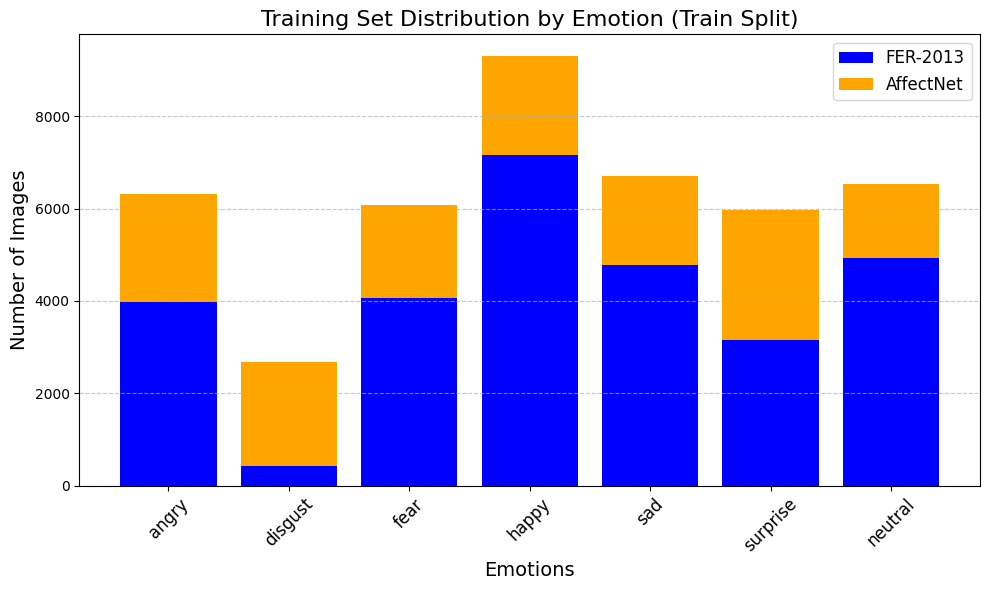

In [50]:
def display_training_set_distribution(output_path, split="train"):
    emotions = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
    fer_counts = []
    affectnet_counts = []

    for emotion in emotions:
        emotion_dir = os.path.join(output_path, split, emotion)
        if os.path.exists(emotion_dir):
            fer_count = len([img for img in os.listdir(emotion_dir) if img.startswith("fer_")])
            affectnet_count = len([img for img in os.listdir(emotion_dir) if img.startswith("affectnet_")])
        else:
            fer_count = 0
            affectnet_count = 0

        fer_counts.append(fer_count)
        affectnet_counts.append(affectnet_count)

    x = range(len(emotions))
    plt.figure(figsize=(10, 6))
    plt.bar(x, fer_counts, label="FER-2013", color="blue")
    plt.bar(x, affectnet_counts, bottom=fer_counts, label="AffectNet", color="orange")
    plt.xticks(x, emotions, rotation=45, fontsize=12)
    plt.xlabel("Emotions", fontsize=14)
    plt.ylabel("Number of Images", fontsize=14)
    plt.title(f"Training Set Distribution by Emotion ({split.capitalize()} Split)", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

display_training_set_distribution(output_path, split="train")

In [51]:
total_train_images = len(merged_train_dataset)
print(f"Total number of images in the training set: {total_train_images}")

Total number of images in the training set: 43586


## Create dataloaders

In [17]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    merged_train_dataset = datasets.ImageFolder(root=os.path.join(output_path, "train"), transform=transform)
    merged_val_dataset = datasets.ImageFolder(root=os.path.join(output_path, "val"), transform=transform)
    merged_test_dataset = datasets.ImageFolder(root=os.path.join(output_path, "test"), transform=transform)

    batch_size = 64
    merged_train_loader = DataLoader(merged_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    merged_val_loader = DataLoader(merged_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    merged_test_loader = DataLoader(merged_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"\nMerged Train Set: {len(merged_train_dataset)} images")
    print(f"Merged Validation Set: {len(merged_val_dataset)} images")
    print(f"Merged Test Set: {len(merged_test_dataset)} images")

    print("\nClass mappings:")
    print(merged_train_dataset.class_to_idx)
except Exception as e:
    print(f"\nError loading merged dataset: {e}")
    print("Make sure the dataset was merged successfully before attempting to create DataLoaders.")


Merged Train Set: 43586 images
Merged Validation Set: 12602 images
Merged Test Set: 10193 images

Class mappings:
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Data Augmentation

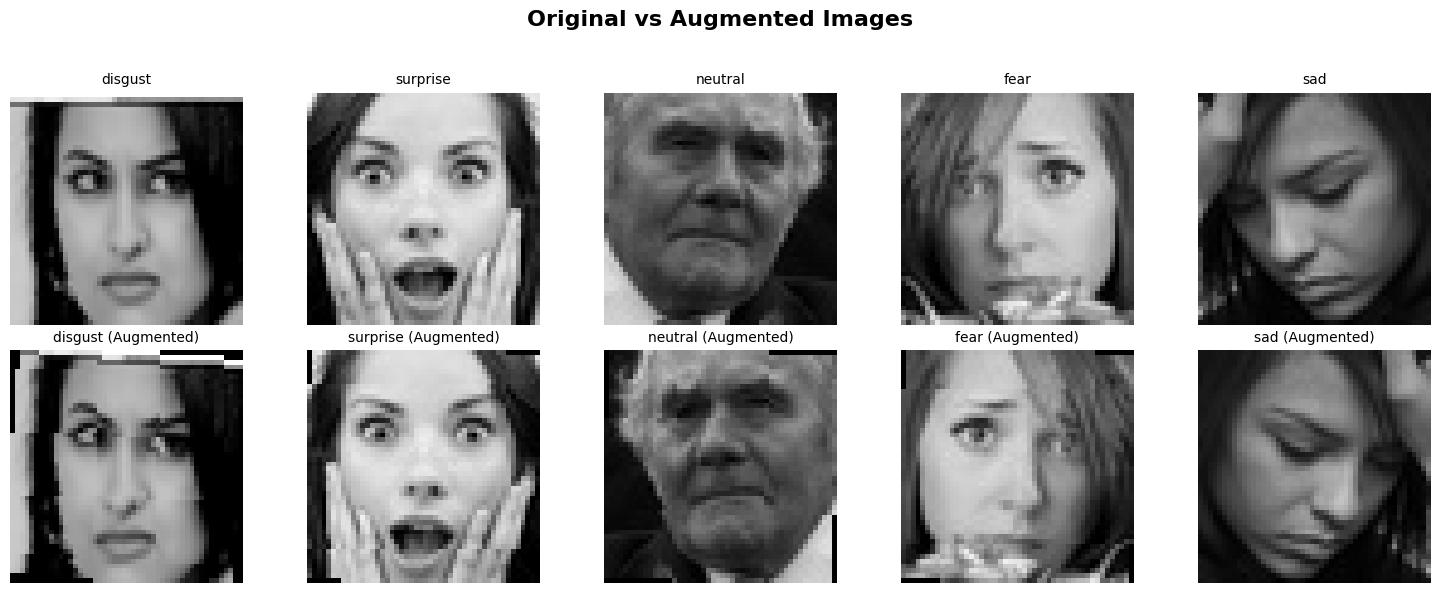

In [18]:
import os
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

def show_augmentation_comparison(dataset_path, class_names, num_samples=5):
    # basic transform for original images (resize and normalize)
    basic_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # minimal augmentation transform
    augmentation_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    original_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=basic_transform)
    augmented_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=augmentation_transform)
    # randomly sample indices
    indices = random.sample(range(len(original_dataset)), num_samples)

    # figure for original and augmented rows
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
    fig.suptitle("Original vs Augmented Images", fontsize=16, fontweight='bold')

    for col, idx in enumerate(indices):
        original_img, label = original_dataset[idx]
        original_img = original_img.permute(1, 2, 0) * 0.5 + 0.5  # Denormalize

        augmented_img, _ = augmented_dataset[idx]
        augmented_img = augmented_img.permute(1, 2, 0) * 0.5 + 0.5  # Denormalize

        axes[0, col].imshow(original_img)
        axes[0, col].set_title(f"{class_names[label]}", fontsize=10)
        axes[0, col].axis('off')

        axes[1, col].imshow(augmented_img)
        axes[1, col].set_title(f"{class_names[label]} (Augmented)", fontsize=10)
        axes[1, col].axis('off')

    axes[0, 0].set_ylabel("Original", fontsize=12, fontweight='bold', labelpad=20)
    axes[1, 0].set_ylabel("Augmented", fontsize=12, fontweight='bold', labelpad=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

try:
    dataset_path = "./merged_emotion_dataset"
    batch_size = 64

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    show_augmentation_comparison(dataset_path, train_dataset.classes)
except Exception as e:
    print(f"Error: {e}")

# Model

## Define model

In [36]:
class DeepVGG19(nn.Module):
    def __init__(self):
        super(DeepVGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=True)

        # unfreeze the last two convolutional blocks (conv4 and conv5)
        for name, param in self.vgg19.features.named_parameters():
            if "28" in name or "29" in name or "30" in name or "31" in name or "32" in name or "33" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # get the flattened feature size for 48x48 input
        self.feature_size = self._get_feature_size()

        # custom CNN classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 7)
        )

        # xavier initialization
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def _get_feature_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 48, 48)
            features = self.vgg19.features(dummy_input)
            features = self.vgg19.avgpool(features)
            return features.view(1, -1).size(1)

    def forward(self, x):
        x = self.vgg19.features(x)
        x = self.vgg19.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, start_epoch=0, best_acc=0.0, checkpoint_path="checkpoint.pth"):
    train_losses, val_losses = [], []
    # mixed precision training
    scaler = torch.amp.GradScaler()

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # forward pass
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "deep_vgg19_best.pth")
            print(f"best model saved with Val Acc: {val_acc:.4f}")

        # save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"checkpoint saved at epoch {epoch+1}")

        scheduler.step()

    return train_losses, val_losses

## Helper functions

In [37]:
def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch} with best Val Acc: {best_acc:.4f}")
        return start_epoch, best_acc, train_losses, val_losses
    else:
        print("No checkpoint found. Starting training from scratch.")
        return 0, 0.0, [], []

def reset_checkpoint(checkpoint_path="checkpoint.pth"):
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        print(f"checkpoint file at '{checkpoint_path}' has been deleted")
    else:
        print(f"no checkpoint file found at '{checkpoint_path}'.")

## Train

In [47]:
reset_checkpoint()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepVGG19().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam([
    {'params': model.vgg19.features[28:].parameters(), 'lr': 5e-4},
    {'params': model.classifier.parameters(), 'lr': 3e-3}
])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
checkpoint_path = "checkpoint.pth"
start_epoch, best_acc, train_losses, val_losses = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    epochs=50, start_epoch=start_epoch, best_acc=best_acc, checkpoint_path=checkpoint_path
)

checkpoint file at 'checkpoint.pth' has been deleted


C:\Users\smuht\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\smuht\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No checkpoint found. Starting training from scratch.
Epoch 1/50: Train Acc: 0.3557, Val Acc: 0.4153
best model saved with Val Acc: 0.4153
checkpoint saved at epoch 1
Epoch 2/50: Train Acc: 0.4194, Val Acc: 0.4759
best model saved with Val Acc: 0.4759
checkpoint saved at epoch 2
Epoch 3/50: Train Acc: 0.4391, Val Acc: 0.4474
checkpoint saved at epoch 3
Epoch 4/50: Train Acc: 0.4550, Val Acc: 0.4990
best model saved with Val Acc: 0.4990
checkpoint saved at epoch 4
Epoch 5/50: Train Acc: 0.4707, Val Acc: 0.5244
best model saved with Val Acc: 0.5244
checkpoint saved at epoch 5
Epoch 6/50: Train Acc: 0.4940, Val Acc: 0.5554
best model saved with Val Acc: 0.5554
checkpoint saved at epoch 6
Epoch 7/50: Train Acc: 0.5083, Val Acc: 0.5502
checkpoint saved at epoch 7
Epoch 8/50: Train Acc: 0.5141, Val Acc: 0.5652
best model saved with Val Acc: 0.5652
checkpoint saved at epoch 8
Epoch 9/50: Train Acc: 0.5209, Val Acc: 0.5617
checkpoint saved at epoch 9
Epoch 10/50: Train Acc: 0.5346, Val Acc: 0.5

# Evaluate

Test Accuracy: 0.7218
Test F1 Score: 0.7208
Test Sensitivity: 0.7218


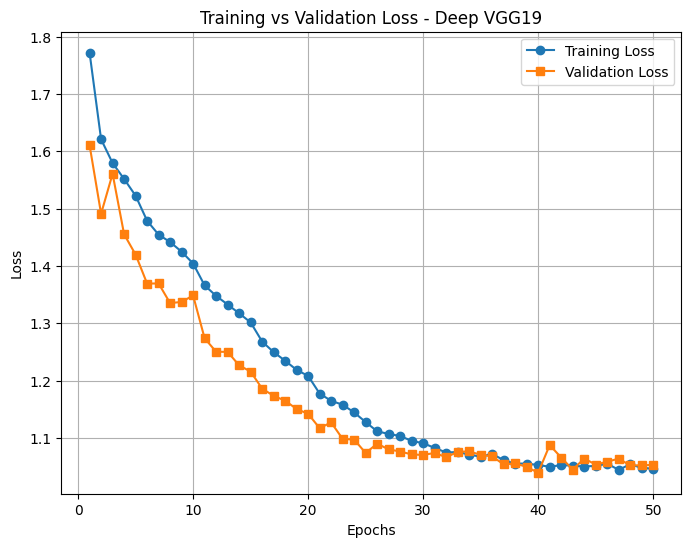

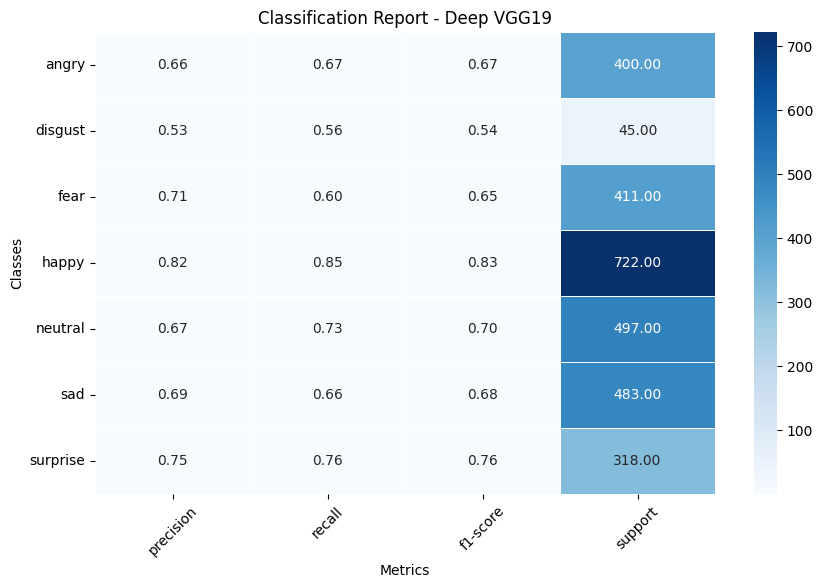

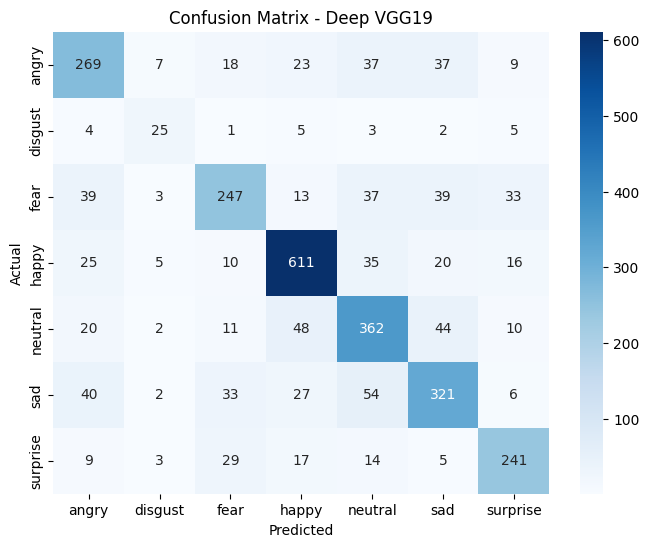

In [48]:
# best model
model.load_state_dict(torch.load("deep_vgg19_best.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# compute metrics
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
f1 = f1_score(y_true, y_pred, average='weighted')
sensitivity = recall_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Sensitivity: {sensitivity:.4f}")

# training vs validation loss graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss - Deep VGG19")
plt.grid(True)
plt.show()

# classification report
class_names = train_dataset.classes
class_report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
class_report_df = pd.DataFrame(class_report_dict).T.round(4)
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-3, :], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Classification Report - Deep VGG19")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Deep VGG19")
plt.show()

# Baselines

## Logistic Regression

Epoch [1/10], Loss: 1.7997
Epoch [2/10], Loss: 1.7337
Epoch [3/10], Loss: 1.7139
Epoch [4/10], Loss: 1.6984
Epoch [5/10], Loss: 1.6860
Epoch [6/10], Loss: 1.6767
Epoch [7/10], Loss: 1.6705
Epoch [8/10], Loss: 1.6662
Epoch [9/10], Loss: 1.6611
Epoch [10/10], Loss: 1.6562


C:\Users\smuht\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\smuht\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\smuht\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

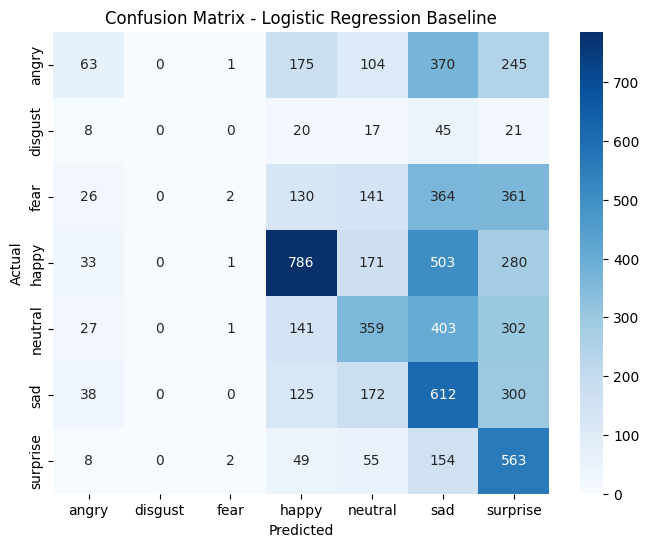

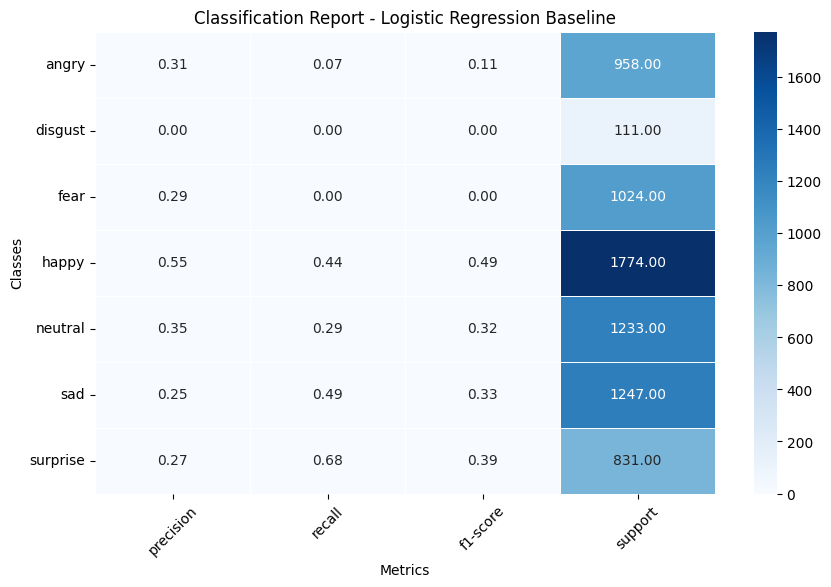

Test Accuracy: 0.3323
F1 Score: 0.2936
Sensitivity (Recall): 0.3323


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = r"C:\Users\smuht\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train"
test_dir = r"C:\Users\smuht\.cache\kagglehub\datasets\msambare\fer2013\versions\1\test"

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

input_dim = 48 * 48
num_classes = 7
model = LogisticRegressionModel(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
class_names = train_dataset.classes
class_report = classification_report(all_labels, all_preds, target_names=class_names)

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression Baseline")
plt.show()

# F1 Score and sensitivity
f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted F1 Score
sensitivity = recall_score(all_labels, all_preds, average='weighted')  # Sensitivity (Recall)

# classification report
class_report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
class_report_df = pd.DataFrame(class_report_dict).T
class_report_df = class_report_df.round(4)  # Round values for better readability
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-3, :], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Classification Report - Logistic Regression Baseline")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")

## Random Forest

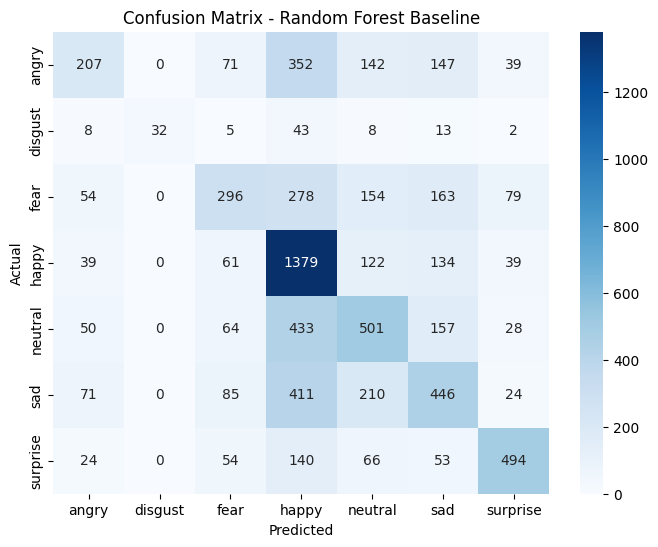

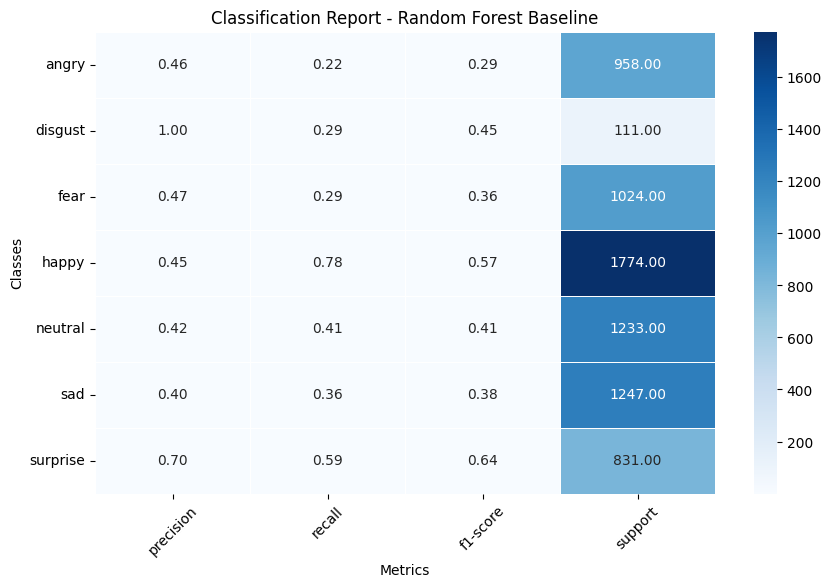

Test Accuracy: 0.4674
F1 Score: 0.4495
Sensitivity (Recall): 0.4674


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score

train_dir = r"C:\Users\smuht\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train"
test_dir = r"C:\Users\smuht\.cache\kagglehub\datasets\msambare\fer2013\versions\1\test"

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# convert dataset to numpy arrays
def dataset_to_numpy(dataset):
    X = []
    y = []
    for img, label in dataset:
        X.append(img.numpy())
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest Baseline")
plt.show()

# F1 Score and sensitivity
f1 = f1_score(y_test, y_pred, average='weighted')
sensitivity = recall_score(y_test, y_pred, average='weighted')

# classification report
class_names = train_dataset.classes
class_report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T
class_report_df = class_report_df.round(4)
plt.figure(figsize=(10, 6))
sns.heatmap(class_report_df.iloc[:-3, :], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Classification Report - Random Forest Baseline")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")